# DVF choosing

In [2]:
import torch
import torch.nn as nn
from torch.functional import F
from utils.utils0 import *
from utils.utils1 import *
from utils.utils1 import ModelParams, model_loader, print_summary#, test_repeat
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

mse = nn.MSELoss()

Device: cuda
Device: cuda


In [4]:
model_params = ModelParams(dataset=2, sup=1)
test_dataset = datagen(model_params.dataset, False, model_params.sup)


Model name:  dataset2_sup1_image1_points0_loss_image0
Model code:  21100_0.001_0_10_1
Model params:  {'dataset': 2, 'sup': 1, 'image': 1, 'points': 0, 'loss_image_case': 0, 'loss_image': MSELoss(), 'loss_affine': <utils.utils1.loss_affine object at 0x7f7388e2bd60>, 'learning_rate': 0.001, 'decay_rate': 0.96, 'start_epoch': 0, 'num_epochs': 10, 'batch_size': 1, 'model_name': 'dataset2_sup1_image1_points0_loss_image0'}


In [18]:
# draw a pair of images from the test set
A, B, affine_param, pt1, pt2, pt3 = list(test_dataset)[0]

In [15]:
A = torch.concat([A, B], dim=0)[0]

In [16]:
pt1.shape, pt2.shape, pt3.shape

(torch.Size([1, 108, 2]), torch.Size([1, 108, 2]), torch.Size([1, 108, 2]))

In [32]:
def transform_points_DVF(points, M, image):
    # transform points using displacement field
    # DVF.shape = (2, H, W)
    # points.shape = (2, N)
    displacement_field = torch.zeros(image.shape[-1], image.shape[-1])
    DVF = transform_to_displacement_field(
        displacement_field.view(1, 1, displacement_field.size(0), displacement_field.size(1)), 
        M.view(1, 2, 3))

    # Reshape tensor points to have dimensions [2, N]
    points = points.long()

    # Use torch.gather to select values from A using indices from points
    result = DVF[:, points[:, 0], points[:, 1]]

    # Reshape result to have dimensions [2, N]
    result = result.t()
    # subtract the result from the original points
    points = points.float()
    result = torch.subtract(points, result)
    return result

# def transform_points_DVF(points, M, image):
#     # transform points using displacement field
#     # DVF.shape = (2, H, W)
#     # points.shape = (2, N)
#     displacement_field = torch.zeros(image.shape[-1], image.shape[-1])
#     DVF = transform_to_displacement_field(
#         displacement_field.view(1, 1, displacement_field.size(0), displacement_field.size(1)), 
#         M.clone().view(1, 2, 3))
#     if isinstance(DVF, torch.Tensor):
#         DVF = DVF.numpy()
#     # loop through each point and apply the transformation
#     for i in range(points.shape[1]):
#         points[:, i] = points[:, i] - DVF[:, int(points[1, i]), int(points[0, i])]
#     return points

In [31]:
transform_points = transform_points_DVF(pt1[0], affine_param[0], A)

torch.Size([2, 108])


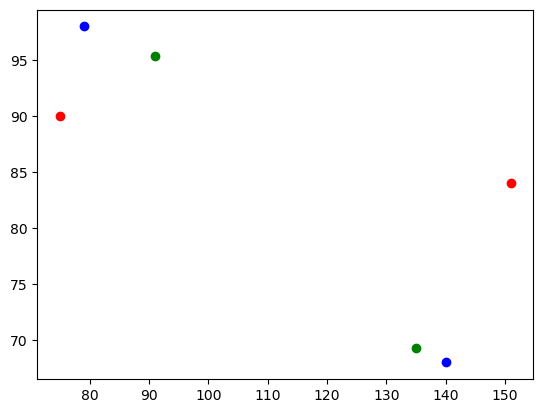

In [35]:
# scatter plot of the points pt1[0], pt2[0], transformed_points, 

plt.scatter(pt1[0][0], pt1[0][1], c='r')
plt.scatter(pt2[0][0], pt2[0][1], c='b')
plt.scatter(transform_points[0], transform_points[1], c='g')
plt.show()

In [17]:
# Reshape tensor points to have dimensions [2, N]
points = pt1[0].long()

# Use torch.gather to select values from A using indices from points
result = A[:, points[:, 0], points[:, 1]]

print(result)


tensor([[0.6353, 0.1961, 0.5686, 0.2588, 0.6941, 0.6902, 0.1725, 0.5255, 0.6863,
         0.3020, 0.2039, 0.3765, 0.2588, 0.3098, 0.0902, 0.5608, 0.7569, 0.7412,
         0.2118, 0.3647, 0.2863, 0.6863, 0.3765, 0.1333, 0.2353, 0.6980, 0.3451,
         0.2627, 0.7255, 0.1020, 0.6549, 0.6745, 0.6549, 0.1843, 0.5294, 0.5255,
         0.2824, 0.9922, 0.4627, 0.2902, 0.2471, 0.1137, 0.7020, 0.6000, 0.3490,
         0.5176, 0.2588, 0.5490, 0.0549, 0.3216, 0.5490, 0.2353, 0.3373, 0.0941,
         0.4196, 0.5843, 0.2667, 0.6902, 0.1725, 0.8275, 0.5490, 0.5176, 0.3725,
         0.5020, 0.3922, 0.2235, 0.1412, 0.2824, 0.5373, 0.0941, 0.0706, 0.7020,
         0.3608, 0.6118, 0.4353, 0.0627, 0.1020, 0.7843, 0.7412, 0.2549, 0.8118,
         0.5216, 0.6314, 0.1255, 0.3529, 0.6157, 0.3412, 0.5098, 0.3882, 0.3686,
         0.0784, 0.5176, 0.5843, 0.0471, 0.4980, 0.6980, 0.6039, 0.3373, 0.5020,
         0.4627, 0.2510, 0.2000, 0.0863, 0.7412, 0.6000, 0.3137, 0.6902, 0.3529]])


In [26]:
result.shape

torch.Size([2, 20])

# Affine transformation

## Method 1

In [27]:
class AffineTransform(nn.Module):
    def __init__(self):
        super(AffineTransform, self).__init__()

    def forward(self, points, matrix):
        points = points.T
        # Add a row of ones to the input points for the affine transformation
        ones = torch.ones(1, points.size(1), dtype=points.dtype, device=points.device)
        points_homogeneous = torch.cat([points, ones], dim=0)

        # Apply the affine transformation
        # print dtype of matrix and points_homogeneous
        transformed_points = torch.mm(matrix, points_homogeneous.float())

        return transformed_points[:2, :]

In [28]:
affine_layer = AffineTransform()

In [29]:
affine_param = torch.tensor([[1.0, 0.0, 0.0],
                                [0.0, 1.0, 0.0]])

In [30]:
transformed_points = affine_layer(points, affine_param)
transformed_points.T

tensor([[141., 175.],
        [196.,  75.],
        [249.,   0.],
        [  9.,  36.],
        [142.,  90.],
        [ 64.,   0.],
        [136., 213.],
        [ 48., 122.],
        [ 76., 243.],
        [148., 242.],
        [ 53., 208.],
        [231.,  69.],
        [ 10., 200.],
        [  0., 148.],
        [ 76., 161.],
        [151., 189.],
        [129., 164.],
        [ 95., 168.],
        [201.,  10.],
        [167.,  97.]])

## Method 2

In [31]:
def transform_to_displacement_field(tensor, tensor_transform, device='cpu'):
    """
    Transforms a tensor using an affine transformation matrix and returns the corresponding displacement field.

    Args:
        tensor (torch.Tensor): The input tensor to transform, with shape (batch_size, channels, height, width).
        tensor_transform (torch.Tensor): The affine transformation matrix, with shape (batch_size, 2, 3).
        device (str, optional): The device to use for the computation (default: 'cpu').

    Returns:
        torch.Tensor: The displacement field tensor, with shape (2, height, width).
    """
    # function code here
    y_size, x_size = tensor.size(2), tensor.size(3)
    deformation_field = F.affine_grid(tensor_transform, tensor.size(), align_corners=False)
    gy, gx = torch.meshgrid(torch.arange(y_size), torch.arange(x_size))
    gy = gy.type(torch.FloatTensor).to(device)
    gx = gx.type(torch.FloatTensor).to(device)
    grid_x = (gx / (x_size - 1) - 0.5) * 2
    grid_y = (gy / (y_size - 1) - 0.5) * 2
    u_x = deformation_field[0, :, :, 0] - grid_x
    u_y = deformation_field[0, :, :, 1] - grid_y
    u_x = u_x / 2 * (x_size - 1)
    u_y = u_y / 2 * (y_size - 1)
    displacement_field = torch.cat((u_x.view(1, y_size, x_size), u_y.view(1, y_size, x_size)), dim=0)
    return displacement_field

In [32]:
def transform_points_DVF(points, M, image):
    # transform points using displacement field
    # DVF.shape = (2, H, W)
    # points.shape = (2, N)
    displacement_field = torch.zeros(image.shape[-1], image.shape[-1])
    DVF = transform_to_displacement_field(
        displacement_field.view(1, 1, displacement_field.size(0), displacement_field.size(1)), 
        M.view(1, 2, 3))

    # Reshape tensor points to have dimensions [2, N]
    points = points.t().long()

    # Use torch.gather to select values from A using indices from points
    result = DVF[:, points[:, 0], points[:, 1]]

    # Reshape result to have dimensions [2, N]
    result = result.t()
    # subtract the result from the original points
    points = points.float()
    result = torch.subtract(points, result)
    return result

In [33]:
transformed_points = transform_points_DVF(points.T, affine_param, A)
transformed_points

tensor([[ 1.4119e+02,  1.7505e+02],
        [ 1.9579e+02,  7.5268e+01],
        [ 2.4850e+02,  4.7461e-01],
        [ 8.6426e+00,  3.5537e+01],
        [ 1.4185e+02,  9.0057e+01],
        [ 6.3502e+01, -2.4805e-01],
        [ 1.3633e+02,  2.1303e+02],
        [ 4.7979e+01,  1.2169e+02],
        [ 7.6451e+01,  2.4280e+02],
        [ 1.4845e+02,  2.4208e+02],
        [ 5.3314e+01,  2.0771e+02],
        [ 2.3077e+02,  6.9404e+01],
        [ 1.0283e+01,  1.9954e+02],
        [ 8.0092e-02,  1.4750e+02],
        [ 7.6131e+01,  1.6080e+02],
        [ 1.5124e+02,  1.8909e+02],
        [ 1.2914e+02,  1.6401e+02],
        [ 9.5158e+01,  1.6787e+02],
        [ 2.0054e+02,  1.0287e+01],
        [ 1.6688e+02,  9.7154e+01]])